<a href="https://colab.research.google.com/github/musamdabu/Fairness-in-AI/blob/main/Fairness_in_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installing necessary packages
!pip install aif360
!pip install fairlearn
!pip install common-utils

In [ ]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.append("../")
import numpy as np
from tqdm import tqdm
from warnings import warn

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from aif360.algorithms.postprocessing.reject_option_classification\
        import RejectOptionClassification
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from ipywidgets import interactive, FloatSlider
from collections import OrderedDict

In [ ]:
## Importing dataset
dataset_used = "adult" # "adult", "compas"
protected_attribute_used = 2 # 1, 2


if dataset_used == "adult":
#     dataset_orig = AdultDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_original = load_preproc_data_adult(['sex'])

    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_original = load_preproc_data_adult(['race'])
    
elif dataset_used == "compas":
#     dataset_orig = COMPASDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_original = load_preproc_data_compas(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_original = load_preproc_data_compas(['race'])

#random seed for calibrated equal odds prediction
np.random.seed(1)

In [ ]:
# Get the dataset and split into train and test
dataset_orig = dataset_original.copy()
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)


In [ ]:
# Print out some of the basic info ex. labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(34189, 18)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['race']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


In [ ]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.097036


In [ ]:
# Transforming training data by reweighing 
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

In [ ]:
### Testing if the transformation has not become worse
assert np.abs(dataset_transf_train.instance_weights.sum()-dataset_orig_train.instance_weights.sum())<1e-6

In [ ]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


In [ ]:
### Testing 
assert np.abs(metric_transf_train.mean_difference()) < 1e-6

In [ ]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train, 
         sample_weight=dataset_orig_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

In [ ]:
# Obtain scores for original validation and test sets
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [ ]:
# Find the optimal classification threshold from the validation set
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.7463
Optimal classification threshold (no reweighing) = 0.2872


In [ ]:

def compute_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    
    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

In [ ]:
# Predictions from original testing data or the default classifier
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
avg_odds_diff_arr_orig = []
stat_par_diff_arr_orig = []
eq_opp_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    stat_par_diff_arr_orig.append(metric_test_bef["Statistical parity difference"])
    eq_opp_diff_arr_orig.append(metric_test_bef["Equal opportunity difference"])

#### Predictions from original testing data

Classification threshold used = 0.2872


 45%|████▌     | 45/100 [00:00<00:00, 135.66it/s]

Balanced accuracy = 0.7437
Statistical parity difference = -0.2435
Average odds difference = -0.1966
Equal opportunity difference = -0.2020


100%|██████████| 100/100 [00:00<00:00, 141.10it/s]


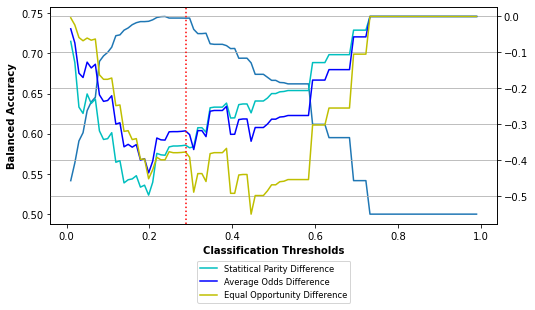

In [ ]:
# Graph showing the optimal threshold and fairness metric values for default classifier
fig, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=10, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='k', fontsize=10, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=10)
ax1.yaxis.set_tick_params(labelsize=10)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, stat_par_diff_arr_orig, color='c')
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='b')
ax2.plot(class_thresh_arr,eq_opp_diff_arr_orig , color='y')
ax2.axvline(best_class_thresh, color='r', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=10)
leg = ax2.legend(labels = ['Statitical Parity Difference', 'Average Odds Difference', 'Equal Opportunity Difference'],bbox_to_anchor=(0.5, -.15),  loc='upper center', fontsize='small')
ax2.grid(True)
display(Markdown("#### For Default Classifier"))

In [ ]:
# Train classifier on tranformed data or fair classifier (reweighing)
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)
y_train_pred = lmod.predict(X_train)

In [ ]:
# Obtain scores for transformed test set
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [ ]:
#Predictions from the transformed test set at the optimal classification threshold
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
avg_odds_diff_arr_transf = []
stat_par_diff_arr_transf = []
eq_opp_diff_arr_transf = []
print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    stat_par_diff_arr_transf.append(metric_test_aft["Statistical parity difference"])
    eq_opp_diff_arr_transf.append(metric_test_aft["Equal opportunity difference"])

#### Predictions from transformed testing data

Classification threshold used = 0.2872


 49%|████▉     | 49/100 [00:00<00:00, 118.63it/s]

Balanced accuracy = 0.7134
Statistical parity difference = -0.0705
Average odds difference = 0.0188
Equal opportunity difference = 0.0293


100%|██████████| 100/100 [00:00<00:00, 121.07it/s]


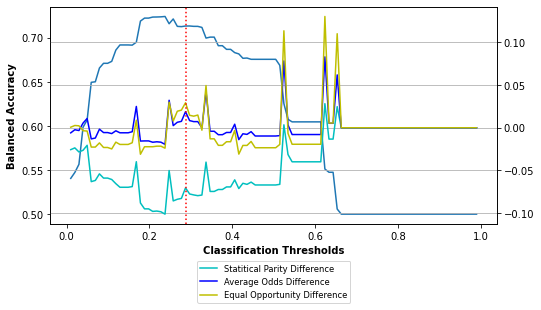

In [ ]:
# Graph showing the optimal threshold and fairness metric values for fair classifier (reweighing)
fig, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=10, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='k', fontsize=10, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=10)
ax1.yaxis.set_tick_params(labelsize=10)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, stat_par_diff_arr_transf, color='c')
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='b')
ax2.plot(class_thresh_arr,eq_opp_diff_arr_transf , color='y')
ax2.axvline(best_class_thresh, color='r', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=10)
leg = ax2.legend(labels = ['Statitical Parity Difference', 'Average Odds Difference', 'Equal Opportunity Difference'],bbox_to_anchor=(0.5, -.15),  loc='upper center', fontsize='small')
ax2.grid(True)

In [ ]:
#Reject_option_classification

# Metric used (should be one of allowed_metrics)
allowed_metrics =  ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]

metric_name = "Statistical parity difference"
if metric_name not in allowed_metrics:
    raise ValueError("Metric name should be one of allowed metrics")
# Upper and lower bound on the fairness metric used
metric_ub = 0.05
metric_lb = -0.05

In [ ]:
# Get the dataset and split into train and test
dataset_orig_train_post = dataset_orig_train.copy()
dataset_orig_valid_post = dataset_orig_valid.copy()
dataset_orig_test_post = dataset_orig_test.copy()


In [ ]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train_post = scale_orig.fit_transform(dataset_orig_train_post.features)
y_train_post = dataset_orig_train_post.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train_post, y_train_post)
y_train_pred_post = lmod.predict(X_train_post)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train_post.favorable_label)[0][0]

dataset_orig_train_pred_post = dataset_orig_train_post.copy(deepcopy=True)
dataset_orig_train_pred_post.labels = y_train_pred_post

In [ ]:
dataset_orig_valid_pred_post = dataset_orig_valid_post.copy(deepcopy=True)
X_valid_post = scale_orig.transform(dataset_orig_valid_pred_post.features)
y_valid_post = dataset_orig_valid_pred_post.labels
dataset_orig_valid_pred_post.scores = lmod.predict_proba(X_valid_post)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred_post = dataset_orig_test_post.copy(deepcopy=True)
X_test_post = scale_orig.transform(dataset_orig_test_pred_post.features)
y_test_post = dataset_orig_test_pred_post.labels
dataset_orig_test_pred_post.scores = lmod.predict_proba(X_test_post)[:,pos_ind].reshape(-1,1)


In [ ]:
num_thresh = 100
ba_arr_post = np.zeros(num_thresh)
class_thresh_arr_post = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh_post in enumerate(class_thresh_arr_post):
    
    fav_inds_post = dataset_orig_valid_pred_post.scores > class_thresh_post
    dataset_orig_valid_pred_post.labels[fav_inds_post] = dataset_orig_valid_pred_post.favorable_label
    dataset_orig_valid_pred_post.labels[~fav_inds_post] = dataset_orig_valid_pred_post.unfavorable_label
    
    classified_metric_orig_valid_post = ClassificationMetric(dataset_orig_valid_post,
                                             dataset_orig_valid_pred_post, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr_post[idx] = 0.5*(classified_metric_orig_valid_post.true_positive_rate()\
                       +classified_metric_orig_valid_post.true_negative_rate())

best_ind_post = np.where(ba_arr_post == np.max(ba_arr_post))[0][0]
best_class_thresh_post = class_thresh_arr_post[best_ind_post]

print("Best balanced accuracy (no fairness constraints) = %.4f" % np.max(ba_arr_post))
print("Optimal classification threshold (no fairness constraints) = %.4f" % best_class_thresh_post)

Best balanced accuracy (no fairness constraints) = 0.7463
Optimal classification threshold (no fairness constraints) = 0.2872


In [ ]:
ROC = RejectOptionClassification(unprivileged_groups=unprivileged_groups, 
                                 privileged_groups=privileged_groups, 
                                 low_class_thresh=0.01, high_class_thresh=0.99,
                                  num_class_thresh=100, num_ROC_margin=50,
                                  metric_name=metric_name,
                                  metric_ub=metric_ub, metric_lb=metric_lb)
ROC = ROC.fit(dataset_orig_valid_post, dataset_orig_valid_pred_post)

In [ ]:
print("Optimal classification threshold (with fairness constraints) = %.4f" % ROC.classification_threshold)
print("Optimal ROC margin = %.4f" % ROC.ROC_margin)

Optimal classification threshold (with fairness constraints) = 0.1981
Optimal ROC margin = 0.1011


In [ ]:
# Metrics for the test set
fav_inds_post = dataset_orig_valid_pred_post.scores > best_class_thresh_post
dataset_orig_valid_pred_post.labels[fav_inds_post] = dataset_orig_valid_pred_post.favorable_label
dataset_orig_valid_pred_post.labels[~fav_inds_post] = dataset_orig_valid_pred_post.unfavorable_label

display(Markdown("#### Validation set"))
display(Markdown("##### Raw predictions - No fairness constraints, only maximizing balanced accuracy"))

metric_valid_bef_post = compute_metrics(dataset_orig_valid_post, dataset_orig_valid_pred_post, 
                unprivileged_groups, privileged_groups)

#### Validation set

##### Raw predictions - No fairness constraints, only maximizing balanced accuracy

Balanced accuracy = 0.7463
Statistical parity difference = -0.3670
Average odds difference = -0.3140
Equal opportunity difference = -0.3666


In [ ]:
# Transform the validation set
dataset_transf_valid_pred_post = ROC.predict(dataset_orig_valid_pred_post)

display(Markdown("#### Validation set"))
display(Markdown("##### Transformed predictions - With fairness constraints"))
metric_valid_aft_post = compute_metrics(dataset_orig_valid_post, dataset_transf_valid_pred_post, 
                unprivileged_groups, privileged_groups)

#### Validation set

##### Transformed predictions - With fairness constraints

Balanced accuracy = 0.7090
Statistical parity difference = -0.0454
Average odds difference = 0.0363
Equal opportunity difference = 0.0197


In [ ]:
# Testing: Check if the metric optimized has not become worse
assert np.abs(metric_valid_aft_post[metric_name]) <= np.abs(metric_valid_bef_post[metric_name])


In [ ]:
# Metrics for the test set
fav_inds_post = dataset_orig_test_pred_post.scores > best_class_thresh_post
dataset_orig_test_pred_post.labels[fav_inds_post] = dataset_orig_test_pred_post.favorable_label
dataset_orig_test_pred_post.labels[~fav_inds_post] = dataset_orig_test_pred_post.unfavorable_label

display(Markdown("#### Test set"))
display(Markdown("##### Raw predictions - No fairness constraints, only maximizing balanced accuracy"))
print("Classification threshold used = %.4f" % best_class_thresh_post)
metric_test_bef_post = compute_metrics(dataset_orig_test_post, dataset_orig_test_pred_post, 
                unprivileged_groups, privileged_groups)

#### Test set

##### Raw predictions - No fairness constraints, only maximizing balanced accuracy

Classification threshold used = 0.2872
Balanced accuracy = 0.7437
Statistical parity difference = -0.3580
Average odds difference = -0.3181
Equal opportunity difference = -0.3769


In [ ]:
# Metrics for the transformed test set
dataset_transf_test_pred_post = ROC.predict(dataset_orig_test_pred_post)

display(Markdown("#### Test set"))
display(Markdown("##### Transformed predictions - With fairness constraints"))
print("Classification threshold used = %.4f" % ROC.classification_threshold)
metric_test_aft_post = compute_metrics(dataset_orig_test_post, dataset_transf_test_pred_post, 
                unprivileged_groups, privileged_groups)

#### Test set

##### Transformed predictions - With fairness constraints

Classification threshold used = 0.1981
Balanced accuracy = 0.7141
Statistical parity difference = -0.0402
Average odds difference = 0.0423
Equal opportunity difference = 0.0407
